# BioInf

## Read Fasta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

In [4]:
def get_info(filename):
    from re import sub, search

    res = []
    inf = []
    sequence = None
    info = None
    
    fh = open(filename)

    for line in fh:
        if search(">.*", line):
                if sequence is not None and info is not None and sequence != "":
                    res.append(sequence)
                    inf.append(info)
                info = line              
                sequence = ""
        else:
            if sequence is None: return None
            else: sequence += sub("\s","",line)

    if sequence is not None and info is not None and sequence != "":
                    res.append(sequence)
                    inf.append(info)
    fh.close()

    return (inf, res)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\marta\AppData\Local\Temp\ipykernel_22708\2607773158.py:20: SyntaxWarning: invalid escape sequence '\s'
  else: sequence += sub("\s","",line)


In [5]:
def read_fasta(filename):
    dic={}
    (infos,sequencias)=get_info(filename)

    for i in range(len(infos)):
        info=infos[i]
        index=info.find("[")
        species=info[index+1:-2]
        dic[species]=sequencias[i]
    return dic


## Pre-processing of the DNA sequence

Validate DNA sequence

In [6]:
def validate_dna (dna_seq):
    seqm = dna_seq.upper()
    valid = seqm.count("A") + seqm.count("C") + seqm.count("G") + seqm.count("T")
    if valid == len(seqm): return True
    else: return False

Get the reverse complement sequence

In [7]:
complement={
    "A": "T",
    "T": "A",
    "C": "G",
    "G": "C"
}

def reverse_complement (dna_seq):
    comp=''
    for nuc in dna_seq:
        comp+=complement[nuc]
    
    return comp[::-1]

Transcription (oculted) and Translation of the DNA sequence into an aminoacids chain

In [8]:
def translate_codon (cod):
    tc = {"GCT":"A", "GCC":"A", "GCA":"A", "GCG":"A",
      "TGT":"C", "TGC":"C",
      "GAT":"D", "GAC":"D",
      "GAA":"E", "GAG":"E",
      "TTT":"F", "TTC":"F",
      "GGT":"G", "GGC":"G", "GGA":"G", "GGG":"G",
      "CAT":"H", "CAC":"H",
      "ATA":"I", "ATT":"I", "ATC":"I",
      "AAA":"K", "AAG":"K",
      "TTA":"L", "TTG":"L", "CTT":"L", "CTC":"L", "CTA":"L", "CTG":"L",
      "ATG":"M", "AAT":"N", "AAC":"N",
      "CCT":"P", "CCC":"P", "CCA":"P", "CCG":"P",
      "CAA":"Q", "CAG":"Q",
      "CGT":"R", "CGC":"R", "CGA":"R", "CGG":"R", "AGA":"R", "AGG":"R",
      "TCT":"S", "TCC":"S", "TCA":"S", "TCG":"S", "AGT":"S", "AGC":"S",
      "ACT":"T", "ACC":"T", "ACA":"T", "ACG":"T",
      "GTT":"V", "GTC":"V", "GTA":"V", "GTG":"V",
      "TGG":"W",
      "TAT":"Y", "TAC":"Y",
      "TAA":"_", "TAG":"_", "TGA":"_"}
    if cod in tc: return tc[cod]
    else: return None


def translate_seq (dna_seq, ini_pos = 0):
    seq_aa = ""
    for i in range(ini_pos, len(dna_seq)-2, 3):
        codon=dna_seq[i]+dna_seq[i+1]+dna_seq[i+2]
        seq_aa+=translate_codon(codon)
    return seq_aa

Compute the (transcription and) translation of the 6 reading frames of the DNA  sequence into aminoacids chains

In [9]:
def reading_frames (dna_seq):
    res = []
    res.append(translate_seq(dna_seq,0))
    res.append(translate_seq(dna_seq,1))
    res.append(translate_seq(dna_seq,2))
    rc = reverse_complement(dna_seq)
    res.append(translate_seq(rc,0))
    res.append(translate_seq(rc,1))
    res.append(translate_seq(rc,2))
    return res

Search for proteins in a aminoacids chain

In [10]:
def all_proteins_rf (aa_seq):
    aa_seq = aa_seq.upper()
    current_prot = []
    proteins = []
    for aa in aa_seq:
        if aa == "_":
            if current_prot:
                for p in current_prot:
                    proteins.append(p)
                current_prot = []
        else:
            if aa == "M":
                current_prot.append("")
            for i in range(len(current_prot)):
                current_prot[i] += aa
    return proteins

Search for all proteins in the six reading frames

In [11]:
def all_orfs (dna_seq):
    res = []
    translations= reading_frames(dna_seq)
    
    for trans in translations:
        res+=all_proteins_rf(trans)
                
    return res

Acording to research this protein has more than 270 aminoacids in every species to be analised

In [12]:
def all_orfs_longproteins (dna_seq, minsize = 270):
    
    all = all_orfs(dna_seq)
    res=[]
    for s in all:
        if len(s)>minsize:
            res.append(s)
    
    res2=sorted(res, key=len)

    return res2

Program that performs this analysis when given a DNA sequence and returns a list of long proteins

In [13]:
def pre_process(dna):
    assert validate_dna(dna), "Invalid DNA sequence"
    return all_orfs_longproteins(dna)

Visual alignment

In [14]:
def create_matrix(nrows, ncols):
    """Create an empty matrix filled with zeros."""
    mat = []
    for i in range(nrows):
        mat.append([])
        for j in range(ncols):
            mat[i].append(0)
    return mat

def dotplot(seq1, seq2):
    """Generate a standard dot plot for sequence alignment."""
    mat = create_matrix(len(seq1), len(seq2))
    for i in range(len(seq1)):
        for j in range(len(seq2)):
            if seq1[i] == seq2[j]:  # Mark match
                mat[i][j] = 1  

    return mat

def extended_dotplot (seq1, seq2, window, stringency):
    """ extended dotplot with window and stringency parameters """
    mat = create_matrix(len(seq1), len(seq2))
    start = int(window/2)
    for i in range(start,len(seq1)-start):
        for j in range(start, len(seq2)-start):
            matches = 0
            l = j - start
            for k in range(i-start, i+start+1):
                if seq1[k] == seq2[l]:
                    matches += 1
                    l += 1
                    if matches >= stringency:
                        mat[i][j] = 1
    return mat 

def plot_dotplot(mat, seq1, seq2, title="Dot Plot"):
    """Plot the dot plot matrix."""
    plt.figure(figsize=(6, 6))
    plt.imshow(mat, cmap="Greys", origin="upper", aspect="auto")
    plt.xticks(ticks=np.arange(len(seq2)), labels=list(seq2), fontsize=8)
    plt.yticks(ticks=np.arange(len(seq1)), labels=list(seq1), fontsize=8)
    plt.xlabel("Sequence 2")
    plt.ylabel("Sequence 1")
    plt.title(title)
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.show()

## MSA

não sei oq eq isso significa, problemas para mais tarde

## Main Project

Protein fasta - resulting from downloading by Smart-blast-p search: https://blast.ncbi.nlm.nih.gov/Blast.cgi

DNA fasta - resulting from downloading by blast search: https://blast.ncbi.nlm.nih.gov/Blast.cgi

In [15]:
def main(filename, type, n=10):
    if type=="aa":
        protein_by_species = read_fasta(filename)

    elif type=="dna":
        dna_by_species = read_fasta(filename)
        protein_by_species={}

        for species in dna_by_species.keys():
            protein=pre_process(dna_by_species[species])[0]
            protein_by_species[species]=protein

    return protein_by_species

### 2. Search for similar sequences in relevant databases 

In [17]:
def detect_sequence_type(sequence):
    """Detect whether the sequence is DNA or protein."""
    dna_bases = set("ATCG")
    sequence_set = set(sequence.upper())
    if sequence_set.issubset(dna_bases):
        return "DNA"
    else:
        return "Protein"

In [18]:
def choose_blast_tool(sequence_type):
    """Choose the appropriate BLAST tool."""
    if sequence_type == "DNA":
        return "blastn"
    else:
        return "blastp"

In [19]:
def run_blast(sequence, program, database="nr"):
    """Perform a BLAST search using NCBI BLAST API."""
    url = "https://blast.ncbi.nlm.nih.gov/Blast.cgi"
    params = {
        "CMD": "Put",
        "PROGRAM": program,
        "DATABASE": database,
        "QUERY": sequence,
    }
    response = requests.post(url, data=params)
    if response.status_code == 200:
        print("BLAST search submitted successfully.")
        print("Check results on NCBI BLAST website using the provided RID (Request ID).")
    else:
        print("Error submitting BLAST search:", response.status_code)

In [ ]:
def build_map (query, w):
    res = {}
    for i in range(len(query)-w+1):
        subseq = query[i:i+w]
        if subseq in res:
            res[subseq].append(i)
        else:
            res[subseq] = [i]
    return res 

In [ ]:
def get_hits(seq, m, w):
    res = []
    for i in range(len(seq) - w + 1):
        subseq = seq[i:i + w]
        if subseq in m:
            l = m[subseq]
            for ind in l:
                res.append((ind, i))
    return res

In [ ]:
def extends_hit(seq, hit, query, w):
    stq, sts = hit[0], hit[1]
    matfw = 0
    k = 0
    bestk = 0
    while 2 * matfw >= k and stq + w + k < len(query) and sts + w + k < len(seq):
        if query[stq + w + k] == seq[sts + w + k]:
            matfw += 1
            bestk = k + 1
        k += 1
    size = w + bestk

    k = 0
    matbw = 0
    bestk = 0
    while 2 * matbw >= k and stq > k and sts > k:
        if query[stq - k - 1] == seq[sts - k - 1]:
            matbw += 1
            bestk = k + 1
        k += 1
    size += bestk

    return (stq - bestk, sts - bestk, size, w + matfw + matbw)

In [ ]:
def hit_best_score(seq, query, m, w):
    hits = get_hits(seq, m, w)
    bestScore = -1.0
    best = ()
    for h in hits:
        ext = extends_hit(seq, h, query, w)
        score = ext[3]
        if score > bestScore or (score == bestScore and ext[2] < best[2]):
            bestScore = score
            best = ext
    return best

In [20]:
def best_alignment(db, query, w):
    m = build_map(query, w)
    bestScore = -1.0
    res = (0,0,0,0,0)
    for k in range(len(db)):
        bestSeq = hit_best_score(db[k], query, m, w)
        if bestSeq != ():
            score = bestSeq[3]
            if score > bestScore or (score == bestScore and bestSeq[2] < res[2]):
                bestScore = score
                res = (bestSeq[0], bestSeq[1], bestSeq[2], bestSeq[3], k)
    return res if bestScore >= 0 else ()

## Testar o código

Testar o código com as 11 sequencias de aa que saquei da net atraves do link do blast

In [24]:
print(main("seqdump.txt", "aa", 12))

{'Homo sapiens': 'MLTLTRIRTVSYEVRSTFLFISVLEFAVGFLTNAFVFLVNFWDVVKRQALSNSDCVLLCLSISRLFLHGLLFLSAIQLTHFQKLSEPLNHSYQAIIMLWMIANQANLWLAACLSLLYCSKLIRFSHTFLICLASWVSRKISQMLLGIILCSCICTVLCVWCFFSRPHFTVTTVLFMNNNTRLNWQIKDLNLFYSFLFCYLWSVPPFLLFLVSSGMLTVSLGRHMRTMKVYTRNSRDPSLEAHIKALKSLVSFFCFFVISSCAAFISVPLLILWRDKIGVMVCVGIMAACPSGHAAILISGNAKLRRAVMTILLWAQSSLKVRADHKADSRTLC', 'Pan troglodytes': 'MLTLTRIHTVSYEVRSTFLFISVLEFAVGFLTNAFVFLVNFWDVVKRQPLSNSDCVLLCLSISRLFLHGLLFLSAIQLTHFQKLSEPLNHSYQAIIMLWMIANQANLWLAACLSLLYCSKLIRFSHTFLICLASWVSRKISQMLLGIILCSCICTVLCVWCFFSRPHFTVTTVLFMNNNTRLNWQIKDLNLFYSFLFCYLWSVPPFLLFLVSSGMLTVSLGRHMRTMKVYTRDSRDPSLEAHIKALKSLVSFFCFFVISSCAAFISVPLLILWRDKIGVMVCVGIMAACPSGHAAVLISGNAKLRRAVTTILLWAQSSLKVRADHKADSRTLC', 'Gorilla gorilla gorilla': 'MLTLTRIRTVSYEVRSTFLFISVLEFAVGFLTNAFVFLVNFWDVVKRQPLSNSDCVLLCLSISRLFLHGLLFLSAIQLTHFQKLSEPLNHSYQAIIMLWMIANQANLWLAACLSLLYCSKLIRFSHTFLICLASWVSRKISQMLLGIILCSCICTVLCVWCFFSRPHFTVTTVLFMNNNTRLNWQIKDLNLFYSFLFCYLWSVPPFLLFLVSSGMLTVSLGRHMRTMKVYIRDSRDPSLEAHIKALKSLVSFFCFFVISSCA

Testar usando o "fasta" do professor - mexi no documento para ficar em conta de como o blast faz o download automatico de ficheiros, mas isto dps tem de ser visto com cuidado e falado com o stor

In [25]:
print(main("sequence_Homo_sapiens.fasta", "dna", 12))

{'Homo sapiens': 'MLTLTRIRTVSYEVRSTFLFISVLEFAVGFLTNAFVFLVNFWDVVKRQALSNSDCVLLCLSISRLFLHGLLFLSAIQLTHFQKLSEPLNHSYQAIIMLWMIANQANLWLAACLSLLYCSKLIRFSHTFLICLASWVSRKISQMLLGIILCSCICTVLCVWCFFSRPHFTVTTVLFMNNNTRLNWQIKDLNLFYSFLFCYLWSVPPFLLFLVSSGMLTVSLGRHMRTMKVYTRNSRDPSLEAHIKALKSLVSFFCFFVISSCAAFISVPLLILWRDKIGVMVCVGIMAACPSGHAAILISGNAKLRRAVMTILLWAQSSLKVRADHKADSRTLC'}


In [26]:
result = main("sequence_Homo_sapiens.fasta", "dna", 12)
print(result['Homo sapiens'])

MLTLTRIRTVSYEVRSTFLFISVLEFAVGFLTNAFVFLVNFWDVVKRQALSNSDCVLLCLSISRLFLHGLLFLSAIQLTHFQKLSEPLNHSYQAIIMLWMIANQANLWLAACLSLLYCSKLIRFSHTFLICLASWVSRKISQMLLGIILCSCICTVLCVWCFFSRPHFTVTTVLFMNNNTRLNWQIKDLNLFYSFLFCYLWSVPPFLLFLVSSGMLTVSLGRHMRTMKVYTRNSRDPSLEAHIKALKSLVSFFCFFVISSCAAFISVPLLILWRDKIGVMVCVGIMAACPSGHAAILISGNAKLRRAVMTILLWAQSSLKVRADHKADSRTLC


In [27]:
result2 = main("seqdump.txt", "aa", 12)
print(result2['Pan troglodytes'])

MLTLTRIHTVSYEVRSTFLFISVLEFAVGFLTNAFVFLVNFWDVVKRQPLSNSDCVLLCLSISRLFLHGLLFLSAIQLTHFQKLSEPLNHSYQAIIMLWMIANQANLWLAACLSLLYCSKLIRFSHTFLICLASWVSRKISQMLLGIILCSCICTVLCVWCFFSRPHFTVTTVLFMNNNTRLNWQIKDLNLFYSFLFCYLWSVPPFLLFLVSSGMLTVSLGRHMRTMKVYTRDSRDPSLEAHIKALKSLVSFFCFFVISSCAAFISVPLLILWRDKIGVMVCVGIMAACPSGHAAVLISGNAKLRRAVTTILLWAQSSLKVRADHKADSRTLC


Testing blast

In [30]:
filename = "seqdump.txt"
data = read_fasta(filename)

for species, sequence in data.items():
    print(f"Performing best_alignment for {species}")
    seq_type = detect_sequence_type(sequence)
    tool = choose_blast_tool(seq_type)
    print(f"Sequence Type: {seq_type}, Using Tool: {tool}")
    result = best_alignment(list(data.values()), sequence, w=11)
    print("Best Alignment Result:", result)

Performing best_alignment for Homo sapiens
Sequence Type: Protein, Using Tool: blastp
Best Alignment Result: (0, 0, 333, 333, 0)
Performing best_alignment for Pan troglodytes
Sequence Type: Protein, Using Tool: blastp
Best Alignment Result: (0, 0, 333, 333, 1)
Performing best_alignment for Gorilla gorilla gorilla
Sequence Type: Protein, Using Tool: blastp
Best Alignment Result: (0, 0, 333, 333, 2)
Performing best_alignment for Pan paniscus
Sequence Type: Protein, Using Tool: blastp
Best Alignment Result: (0, 0, 333, 333, 3)
Performing best_alignment for Pongo pygmaeus
Sequence Type: Protein, Using Tool: blastp
Best Alignment Result: (0, 0, 333, 333, 4)
Performing best_alignment for Nomascus leucogenys
Sequence Type: Protein, Using Tool: blastp
Best Alignment Result: (0, 0, 333, 333, 5)
Performing best_alignment for Symphalangus syndactylus
Sequence Type: Protein, Using Tool: blastp
Best Alignment Result: (0, 0, 333, 333, 6)
Performing best_alignment for Pongo abelii
Sequence Type: Prot

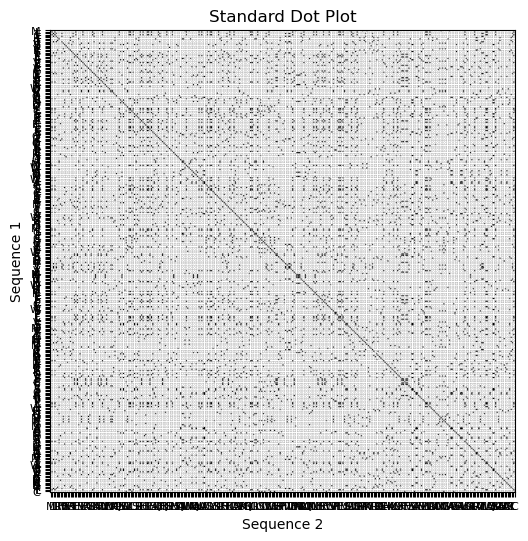

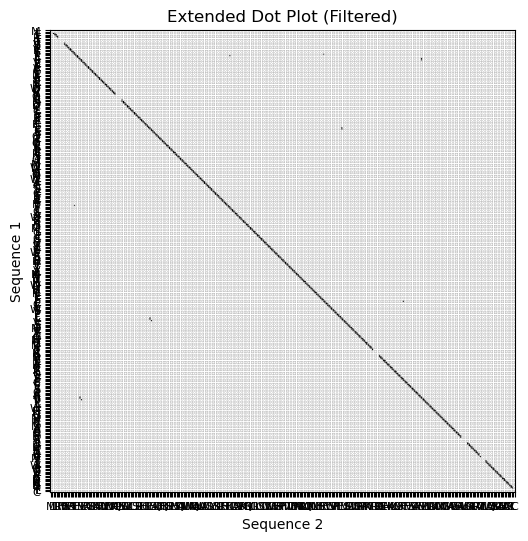

In [30]:
# Test with example sequences
result1 = main("sequence_Homo_sapiens.fasta", "dna", 12)
result2 = main("seqdump.txt", "aa", 12)

seq1 = result1['Homo sapiens']
seq2 = result2['Pan troglodytes']

# Generate standard dot plot
mat1 = dotplot(seq1, seq2)
plot_dotplot(mat1, seq1, seq2, title="Standard Dot Plot")

# Generate extended dot plot with window size 5 and stringency 4
mat2 = extended_dotplot(seq1, seq2, window=5, stringency=4)
plot_dotplot(mat2, seq1, seq2, title="Extended Dot Plot (Filtered)")

## Bibliography

https://www.ncbi.nlm.nih.gov

https://blast.ncbi.nlm.nih.gov

Professor's notes and programs